In [1]:
import sys
import logging
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
from pyproj import Transformer, CRS
from shapely.geometry import Polygon, Point
import h5pyd as h5py
import icesat2

In [2]:
# Configure Logging
sliderule_logger = logging.getLogger("sliderule.sliderule")
sliderule_logger.setLevel(logging.INFO)
icesat2_logger = logging.getLogger("icesat2.icesat2")
icesat2_logger.setLevel(logging.INFO)
# Create Console Output
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
sliderule_logger.addHandler(ch)
icesat2_logger.addHandler(ch)

In [3]:
# Configure Session
icesat2.init("http://44.227.4.67:9081", False)
region = [ {"lon": -108.3435200747503, "lat": 38.89102961045247},
           {"lon": -107.7677425431139, "lat": 38.90611184543033}, 
           {"lon": -107.7818591266989, "lat": 39.26613714985466},
           {"lon": -108.3605610678553, "lat": 39.25086131372244},
           {"lon": -108.3435200747503, "lat": 38.89102961045247} ]

In [4]:
# Build ATL06 Request
parms = {
    "poly": region,
    "srt": icesat2.SRT_LAND,
    "cnf": icesat2.CNF_SURFACE_HIGH,
    "ats": 10.0,
    "cnt": 10,
    "len": 40.0,
    "res": 20.0,
    "maxi": 1
}

# Request ATL06 Data
rsps = icesat2.atl06p(parms, "atl03-cloud")

# Build Dataframe of SlideRule Responses
df = pd.DataFrame(data=list(zip(rsps["h_mean"], rsps["lat"], rsps["lon"], rsps["spot"])), index=rsps["segment_id"], columns=["h_mean", "latitude", "longitude", "spot"])

unable to process resource ATL03_20181110092841_06530106_003_01.h5: no elements
Results returned for 1 out of 59 resources
Results returned for 2 out of 59 resources
Results returned for 3 out of 59 resources
Results returned for 4 out of 59 resources
Results returned for 5 out of 59 resources
unable to process resource ATL03_20190112181620_02340202_003_01.h5: no elements
Results returned for 6 out of 59 resources
unable to process resource ATL03_20190209050825_06530206_003_01.h5: no elements
Results returned for 7 out of 59 resources
Results returned for 8 out of 59 resources
Results returned for 9 out of 59 resources
unable to process resource ATL03_20190116180755_02950202_003_01.h5: no elements
Results returned for 10 out of 59 resources
Results returned for 11 out of 59 resources
Results returned for 12 out of 59 resources
unable to process resource ATL03_20190214164413_07370202_003_01.h5: no elements
Results returned for 13 out of 59 resources
Results returned for 14 out of 59 res

In [5]:
# Setup Columns
columns = ["h_li", "latitude", "longitude"]

In [6]:
# Query ATL06 Files from NASA CMR System
resources = icesat2.cmr(region, short_name='ATL06')

In [7]:
# Build empty atl06 dataset
atl06 = {}
for element in columns:
    atl06[element] = []

# Read each file
for resource in resources:
    
    try:
        # Open file
        print("Reading {}".format(resource))
        f = h5py.File("/hsds/ATL06/"+resource, "r")

        # Build data dictionary of each element
        for spot in ["gt1l", "gt1r", "gt2l", "gt2r", "gt3l", "gt3r"]:
            data = {}
            for element in columns:
                dataset = spot + "/land_ice_segments/" + element
                data[element] = f[dataset]
                s = sum(data[element]) # guarantee read of all data
            for element in columns:
                atl06[element] += data[element]
    except Exception as e:
        print("Error reading {}: {}".format(resource, e))


Reading ATL06_20181017222812_02950102_003_01.h5
Reading ATL06_20181110092841_06530106_003_01.h5
Reading ATL06_20181114092019_07140106_003_01.h5
Reading ATL06_20181115210428_07370102_003_01.h5
Reading ATL06_20181213075606_11560106_003_01.h5
Reading ATL06_20181214194017_11790102_003_01.h5
Reading ATL06_20190111063212_02110206_003_01.h5
Reading ATL06_20190112181620_02340202_003_01.h5
Reading ATL06_20190116180755_02950202_003_01.h5
Reading ATL06_20190209050825_06530206_003_01.h5
Reading ATL06_20190213050003_07140206_003_01.h5
Reading ATL06_20190214164413_07370202_003_01.h5
Reading ATL06_20190314033606_11560206_003_01.h5
Reading ATL06_20190315152016_11790202_003_01.h5
Reading ATL06_20190412021205_02110306_003_01.h5
Reading ATL06_20190413135615_02340302_003_01.h5
Reading ATL06_20190417134754_02950302_003_01.h5
Reading ATL06_20190511004804_06530306_003_01.h5
Reading ATL06_20190515003943_07140306_003_01.h5
Reading ATL06_20190516122353_07370302_003_01.h5
Reading ATL06_20190612231542_11560306_00

In [8]:
# Create Projection Transformer
transformer = Transformer.from_crs(4326, 3857) # GPS to Web Mercator

# Project Polygon
pregion = []
for point in region:
    ppoint = transformer.transform(point["lat"], point["lon"])
    pregion.append(ppoint)

# Build empty trimmed region
trimmed = {}
for element in columns:
    trimmed[element] = []
    
# Trim Results
polygon = Polygon(pregion)
for lat,lon,h in zip(atl06["latitude"],atl06["longitude"],atl06["h_li"]):
    c = transformer.transform(lat, lon)
    point = Point(c[0], c[1])
    if point.within(polygon):
        trimmed["latitude"].append(lat)
        trimmed["longitude"].append(lon)
        trimmed["h_li"].append(h)
atl06 = trimmed

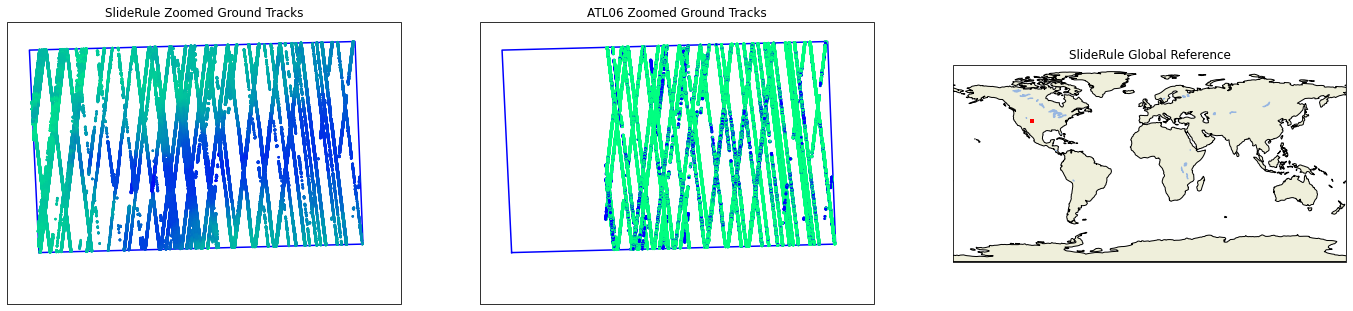

In [9]:
# Create Plot
fig = plt.figure(num=None, figsize=(24, 12))
box_lon = [e["lon"] for e in region]
box_lat = [e["lat"] for e in region]

# Plot Ground Tracks
ax1 = plt.subplot(131,projection=cartopy.crs.PlateCarree())
ax1.set_title("SlideRule Zoomed Ground Tracks")
ax1.scatter(df["longitude"].values, df["latitude"].values, s=2.5, c=df["h_mean"], cmap='winter_r', zorder=3, transform=cartopy.crs.PlateCarree())
ax1.set_extent((-108.4,-107.7,38.8,39.3),crs=cartopy.crs.PlateCarree())
ax1.plot(box_lon, box_lat, linewidth=1.5, color='b', zorder=2, transform=cartopy.crs.Geodetic())

# Plot Ground Tracks
ax2 = plt.subplot(132,projection=cartopy.crs.PlateCarree())
ax2.set_title("ATL06 Zoomed Ground Tracks")
ax2.scatter(atl06["longitude"], atl06["latitude"], s=2.5, c=atl06["h_li"], cmap='winter_r', zorder=3, transform=cartopy.crs.PlateCarree())
ax2.set_extent((-108.4,-107.7,38.8,39.3),crs=cartopy.crs.PlateCarree())
ax2.plot(box_lon, box_lat, linewidth=1.5, color='b', zorder=2, transform=cartopy.crs.Geodetic())

# Plot SlideRule Global View
ax3 = plt.subplot(133,projection=cartopy.crs.PlateCarree())
ax3.set_title("SlideRule Global Reference")
ax3.scatter(df["longitude"].values, df["latitude"].values, s=2.5, color='r', zorder=3, transform=cartopy.crs.PlateCarree())
ax3.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax3.add_feature(cartopy.feature.LAKES)
ax3.set_extent((-180,180,-90,90),crs=cartopy.crs.PlateCarree())

# Show Plot
plt.show()